In [2]:
import os
import copy
import pickle
import warnings
import pandas as pd
import numpy as np
import numpy.ma as ma
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import bootstrap
import deepdish as dd

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import palettable


from astropy.utils.console import ProgressBar
from astropy.table import QTable
plt.rc('text', usetex=True)
rcParams.update({'axes.linewidth': 1.5})
rcParams.update({'xtick.direction': 'in'})
rcParams.update({'ytick.direction': 'in'})
rcParams.update({'xtick.minor.visible': 'True'})
rcParams.update({'ytick.minor.visible': 'True'})
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '8.0'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '4.0'})
rcParams.update({'xtick.minor.width': '1.5'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '8.0'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '4.0'})
rcParams.update({'ytick.minor.width': '1.5'})
rcParams.update({'axes.titlepad': '10.0'})
rcParams.update({'font.size': 25})

In [3]:
h=0.6774 #small h for Hubble constant in TNG

In [4]:
data_dir="/Users/xushuo/work/Submit/Simulation/data/"
fig_dir="/Users/xushuo/work/Papers/Simulation/Figure/"

In [5]:
#load stellar mass measurement
tab=dd.io.load(data_dir+'galaxies_tng100_072_correct.hdf5','/physical_mass')
tab1=dd.io.load(data_dir+'galaxies_tng300_072_correct.hdf5','/physical_mass')

In [6]:
#load SHMR relation 
slope_aper_tab=dd.io.load(data_dir+'galaxies_tng100_072_correct.hdf5','/physical_fit/direct/slope_aperture')
slope_out_tab=dd.io.load(data_dir+'galaxies_tng100_072_correct.hdf5','/physical_fit/direct/slope_outskirt')
inter_aper_tab=dd.io.load(data_dir+'galaxies_tng100_072_correct.hdf5','/physical_fit/direct/inter_aperture')
inter_out_tab=dd.io.load(data_dir+'galaxies_tng100_072_correct.hdf5','/physical_fit/direct/inter_outskirt')

In [7]:
mpeak_aper_tab=dd.io.load(data_dir+'galaxies_tng100_072_correct.hdf5','/physical_fit/direct/mpeak_aperture')
mpeak_out_tab=dd.io.load(data_dir+'galaxies_tng100_072_correct.hdf5','/physical_fit/direct/mpeak_outskirt')

In [8]:
mpeak_aper_tab

aperture_size,mpeak_aper_ins_xy,mpeak_aper_cutnumb_ins_xy,mpeak_aper_ins_yz,mpeak_aper_cutnumb_ins_yz,mpeak_aper_ins_xz,mpeak_aper_cutnumb_ins_xz,mpeak_aper_exs_xy,mpeak_aper_cutnumb_exs_xy,mpeak_aper_exs_yz,mpeak_aper_cutnumb_exs_yz,mpeak_aper_exs_xz,mpeak_aper_cutnumb_exs_xz,mpeak_aper_gal_xy,mpeak_aper_cutnumb_gal_xy,mpeak_aper_gal_yz,mpeak_aper_cutnumb_gal_yz,mpeak_aper_gal_xz,mpeak_aper_cutnumb_gal_xz
int64,float64,int64,float64,int64,float64,int64,float64,int64,float64,int64,float64,int64,float64,int64,float64,int64,float64,int64
10,10.627055287476342,160,10.617788019103239,162,10.76977699967967,93,10.632062137481258,194,10.738480769380017,152,10.686514589117895,172,10.978666236499611,188,10.953225550926588,206,10.94269577404846,212
30,10.860421903137528,148,10.908392964138057,119,10.854238408295108,151,10.91655525362701,159,10.858405303455545,183,10.879503529147618,175,11.119982662222528,221,11.159341402126138,185,11.13424161063387,209
50,10.854231483388538,179,10.84754233559089,184,10.951260335318514,125,10.927261807416563,180,10.904920792634563,185,10.966176150387017,163,11.182231497188527,204,11.192844231754314,195,11.174812873421917,209
75,10.939233832393812,148,10.983224655494247,117,10.925803513086516,154,10.985295000666609,172,10.9757484835269,174,10.947315843470896,182,11.266268397630629,167,11.184124023096494,221,11.26205415569106,169
100,11.021526944231557,108,10.948588995557426,150,10.95129395522353,147,11.007905461716224,170,11.0127586744629,167,10.994199426653935,172,11.169971833812665,233,11.206323985258264,211,11.278088067910392,169
150,10.885033165792427,189,10.9184271705857,173,10.924276967348385,164,11.03376629286229,163,10.97387190196051,184,11.034051825231051,163,11.18647968895216,234,11.22587432851006,209,11.237364521506363,200


In [9]:
slope_aper_tab1=dd.io.load(data_dir+'galaxies_tng300_072_correct.hdf5','/physical_fit/direct/slope_aperture')
slope_out_tab1=dd.io.load(data_dir+'galaxies_tng300_072_correct.hdf5','/physical_fit/direct/slope_outskirt')
inter_aper_tab1=dd.io.load(data_dir+'galaxies_tng300_072_correct.hdf5','/physical_fit/direct/inter_aperture')
inter_out_tab1=dd.io.load(data_dir+'galaxies_tng300_072_correct.hdf5','/physical_fit/direct/inter_outskirt')

In [10]:
mpeak_aper_tab1=dd.io.load(data_dir+'galaxies_tng300_072_correct.hdf5','/physical_fit/direct/mpeak_aperture')
mpeak_out_tab1=dd.io.load(data_dir+'galaxies_tng300_072_correct.hdf5','/physical_fit/direct/mpeak_outskirt')

In [11]:
cmap1=palettable.colorbrewer.sequential.Oranges_4.mpl_colormap
cmap2=palettable.colorbrewer.sequential.Blues_4.mpl_colormap
cmap3=palettable.colorbrewer.sequential.Greens_4.mpl_colormap
cmap_list=[cmap1,cmap2,cmap3]

In [12]:
#data for plot halo mass function
with open(data_dir+"galaxies_tng300_072_all_central_Halomass.txt",'rb') as f: 
    halo0=pickle.load(f)

In [13]:
mask0=(halo0*10**10)>10**11

In [14]:
boxsize=205.0
binlist=np.concatenate((np.arange(11,12.79,0.2),np.arange(12.8,13.71,0.3),np.arange(14,15.5,0.5)))
binsize=binlist[1:]-binlist[:-1]

In [15]:
binlist

array([11. , 11.2, 11.4, 11.6, 11.8, 12. , 12.2, 12.4, 12.6, 12.8, 13.1,
       13.4, 13.7, 14. , 14.5, 15. ])

In [16]:
phi_0=np.histogram(np.log10(halo0[mask0])+10,bins=binlist)[0]

In [17]:
# completeness correction for different stellar mass measure
def mpeakfind(tab,bin_num=30):
    numb,bins=np.histogram(tab,bins=bin_num)
    max_value=max(numb)
    max_index=list(numb).index(max_value)
    mpeak=bins[max_index]
    return mpeak

In [18]:
mask1=(tab1['catsh_primary']==True)&(tab1['proj']=='xy')&(tab1['mass_stellar_ins']>1e10)&(tab1['mass_stellar_exs']>10**10.5)

In [19]:
mpeak=mpeakfind(np.log10(tab1[mask1]['aper_100_gal']-tab1[mask1]['aper_50_gal']))

In [20]:
mask_pk=(np.log10(tab1[mask1]['aper_100_gal']-tab1[mask1]['aper_50_gal'])>mpeak)

In [21]:
#halo mass distribution for stellar mass complete sample
phi_1=np.histogram(np.log10(tab1[mask1]['mass_halo']),bins=binlist)[0]
phi_2=np.histogram(np.log10(tab1[mask1][mask_pk]['mass_halo']),bins=binlist)[0]

In [23]:
norm=(boxsize**3)*binsize

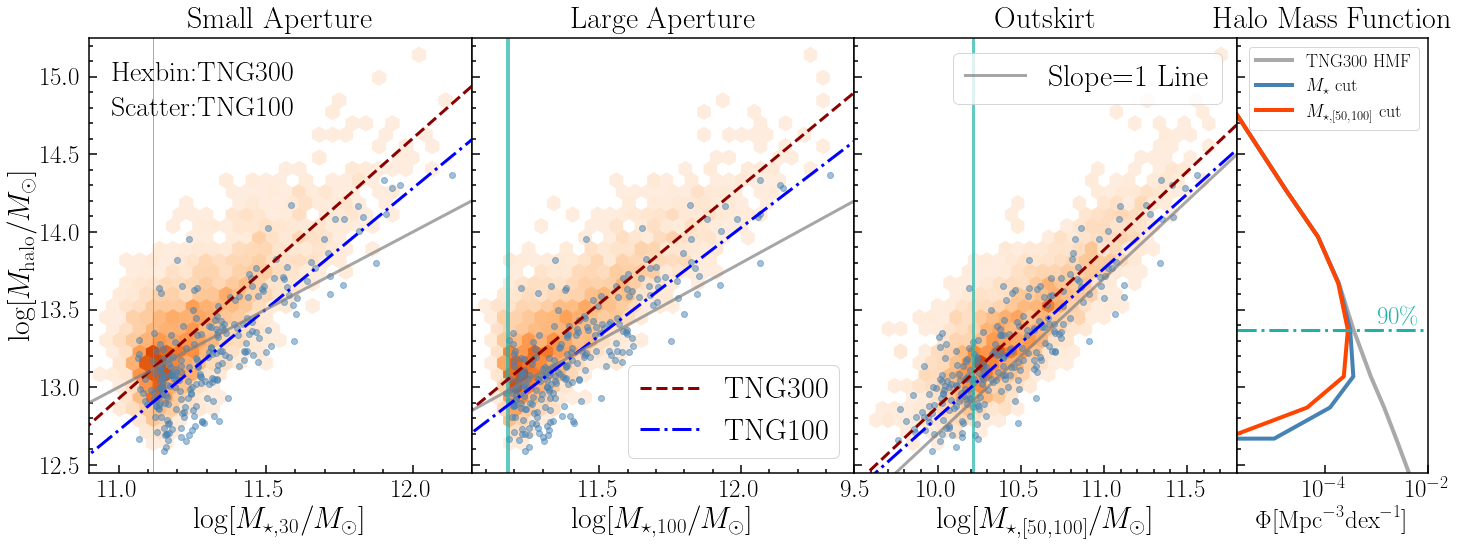

In [31]:
mask=(tab['catsh_primary']==True)&(tab['proj']=='xy')&(tab['mass_stellar_ins']>1e10)&(tab['mass_stellar_exs']>10**10.5)
mask1=(tab1['catsh_primary']==True)&(tab1['proj']=='xy')&(tab1['mass_stellar_ins']>1e10)&(tab1['mass_stellar_exs']>10**10.5)
fig=plt.figure(figsize=(24, 8))
gs = fig.add_gridspec(1,4, hspace=0, wspace=0,width_ratios=(1,1,1,0.5))
(ax1,ax2,ax3,ax4)= gs.subplots(sharex='col', sharey='row')
linelist=np.asarray([9,10,11,12,13])

ax1.hexbin(np.log10(tab1['aper_30_gal'][mask1]), np.log10(tab1['mass_halo'][mask1]/h),gridsize=30,cmap=cmap1,mincnt=1,label='TNG300')
k=slope_aper_tab1[slope_aper_tab1['aperture_size']==30]['slope_aper_gal_xy'][0]
b=inter_aper_tab1[inter_aper_tab1['aperture_size']==30]['inter_aper_gal_xy'][0]
ax1.plot(linelist, k*linelist+b-np.log10(h),c='darkred',ls='--',lw=3)


ax1.scatter(
    np.log10(tab['aper_30_gal'][mask]), np.log10(tab['mass_halo'][mask]/h),c='steelblue',alpha=0.5,label='TNG100')
k=slope_aper_tab[slope_aper_tab['aperture_size']==30]['slope_aper_gal_xy'][0]
b=inter_aper_tab[inter_aper_tab['aperture_size']==30]['inter_aper_gal_xy'][0]
ax1.plot(linelist, k*linelist+b-np.log10(h),c='blue',ls='-.',lw=3)
ax1.plot([10,11,12,13],[12,13,14,15],c='grey',alpha=0.7,ls='-',lw=3)


ax3.hexbin(np.log10(tab1['aper_100_gal'][mask1]-tab1['aper_50_gal'][mask1]), np.log10(tab1['mass_halo'][mask1]/h),gridsize=30,cmap=cmap1,mincnt=1)
k=slope_out_tab1[slope_out_tab1['outskirt_inner_size']==50]['slope_out_gal_xy'][0]
b=inter_out_tab1[inter_out_tab1['outskirt_inner_size']==50]['inter_out_gal_xy'][0]
ax3.plot(linelist, k*linelist+b-np.log10(h),c='darkred',ls='--',lw=3)

ax3.scatter(
    np.log10(tab['aper_100_gal'][mask]-tab['aper_50_gal'][mask]), np.log10(tab['mass_halo'][mask]/h),c='steelblue',alpha=0.5)
k=slope_out_tab[slope_out_tab['outskirt_inner_size']==50]['slope_out_gal_xy'][0]
b=inter_out_tab[inter_out_tab['outskirt_inner_size']==50]['inter_out_gal_xy'][0]
ax3.plot(linelist, k*linelist+b-np.log10(h),c='blue',ls='-.',lw=3)


ax2.hexbin(np.log10(tab1['aper_100_gal'][mask1]), np.log10(tab1['mass_halo'][mask1]/h),gridsize=30,cmap=cmap1,mincnt=1)
k=slope_aper_tab1[slope_aper_tab1['aperture_size']==100]['slope_aper_gal_xy'][0]
b=inter_aper_tab1[inter_aper_tab1['aperture_size']==100]['inter_aper_gal_xy'][0]
ax2.plot(linelist, k*linelist+b-np.log10(h),c='darkred',ls='--',lw=3,label=r'\rm TNG300')

ax2.scatter(
    np.log10(tab['aper_100_gal'][mask]), np.log10(tab['mass_halo'][mask]/h),c='steelblue',alpha=0.5)
k=slope_aper_tab[slope_aper_tab['aperture_size']==100]['slope_aper_gal_xy'][0]
b=inter_aper_tab[inter_aper_tab['aperture_size']==100]['inter_aper_gal_xy'][0]
ax2.plot(linelist, k*linelist+b-np.log10(h),c='blue',ls='-.',lw=3,label=r'\rm TNG100')

ax2.plot([10,11,12,13],[11.8,12.8,13.8,14.8],c='grey',ls='-',lw=3,alpha=0.7)
ax3.plot([9,10,11,12,13],[11.7,12.7,13.7,14.7,15.7],c='grey',ls='-',lw=3,alpha=0.7,label=r'\rm Slope=1 Line')

ax3.legend(fontsize=30)
ax2.legend(fontsize=30)

ax1.axvspan(mpeak_aper_tab1['mpeak_aper_gal_xy'][mpeak_aper_tab1['aperture_size']==30][0],mpeak_aper_tab['mpeak_aper_gal_xy'][mpeak_aper_tab['aperture_size']==30][0]
            ,color='lightseagreen',ec=None,alpha=0.7)
ax2.axvspan(mpeak_aper_tab1['mpeak_aper_gal_xy'][mpeak_aper_tab1['aperture_size']==100][0],mpeak_aper_tab['mpeak_aper_gal_xy'][mpeak_aper_tab['aperture_size']==100][0]
            ,color='lightseagreen',ec=None,alpha=0.7)
ax3.axvspan(mpeak_out_tab['mpeak_out_gal_xy'][mpeak_out_tab['outskirt_inner_size']==50][0],mpeak_out_tab1['mpeak_out_gal_xy'][mpeak_out_tab1['outskirt_inner_size']==50][0]
            ,color='lightseagreen',ec=None,alpha=0.7)


ax1.set_title(r'\rm Small Aperture',fontsize=30)
ax2.set_title(r'\rm Large Aperture',fontsize=30)
ax3.set_title(r'\rm Outskirt',fontsize=30)
ax1.text(0.06, 0.90, r'\rm Hexbin:TNG300', transform=ax1.transAxes, size=28)
ax1.text(0.06, 0.82, r'\rm Scatter:TNG100', transform=ax1.transAxes, size=28)

_ = ax1.set_xlim(10.9, 12.2)
_ = ax2.set_xlim(11.05, 12.4)
_ = ax3.set_xlim(9.5, 11.8)
_ = ax1.set_ylim(12.45, 15.25)

_ = ax1.set_xlabel(r'$\log [M_{\star,30}/M_\odot]$', fontsize=30)
_ = ax2.set_xlabel(r'$\log [M_{\star,100}/M_\odot]$', fontsize=30)
_ = ax3.set_xlabel(r'$\log [M_{\star,[50,100]}/M_\odot]$', fontsize=30)
_ = ax1.set_ylabel(r'$\log [M_{\rm halo}/M_\odot]$', fontsize=30)

ax4.plot(phi_0/norm,(binlist[:-1]+0.1)-np.log10(h),c='darkgrey',label=r'\rm TNG300 HMF',lw=4)
ax4.plot(phi_1/norm,(binlist[:-1]+0.1)-np.log10(h),c='steelblue',label=r'\rm $M_\star$ cut',lw=4)
ax4.plot(phi_2/norm,(binlist[:-1]+0.1)-np.log10(h),c='orangered',label=r'\rm $M_{\star,[50,100]}$ cut',lw=4)
ax4.axhline(comp-np.log10(h),c='lightseagreen',ls='-.',lw=3)
ax4.set_xscale('log')
ax4.text(0.73,0.34,r'$90\%$',transform=ax4.transAxes,color='lightseagreen')
ax4.set_title(r'\rm Halo Mass Function',fontsize=30)
ax4.set_xlabel(r'$\Phi[{\rm Mpc}^{-3}{\rm dex}^{-1}]$');
ax4.legend(fontsize=18)


ax4.set_xlim(10**(-5.7),10**(-2))

plt.savefig(fig_dir+"Fig2.png",dpi=150)

In [26]:
mpeak_aper_tab1['mpeak_aper_gal_xy'][mpeak_aper_tab1['aperture_size']==30]

11.117066385929308


In [27]:
comp=(13.4-13.1)*(0.9-(phi_1/phi_0)[10])/((phi_1/phi_0)[11]-(phi_1/phi_0)[10])+13.1